In [33]:
#1.导入库
import pandas as pd
import polars as pl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer as Tfidf                # TfidfVectorizer 用于将姓名文本转换为特征向量
from sklearn.preprocessing import LabelEncoder as LE                                # LabelEncoder 用于将标签文本转换为数字
import time
from torch.utils.data import DataLoader, TensorDataset  
#import cudf

: 

In [34]:
#2.读取数据集
dfu = pd.read_parquet("hf://datasets/jbrazzy/credit-card/data/train-00000-of-00001-54dc80341a52d64e.parquet")
print(dfu)

          ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1    20000.0    2          2         1   24      2      2     -1   
1          2   120000.0    2          2         2   26     -1      2      0   
2          3    90000.0    2          2         2   34      0      0      0   
3          4    50000.0    2          2         1   37      0      0      0   
4          5    50000.0    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996   220000.0    1          3         1   39      0      0      0   
29996  29997   150000.0    1          3         2   43     -1     -1     -1   
29997  29998    30000.0    1          2         2   37      4      3      2   
29998  29999    80000.0    1          3         1   41      1     -1      0   
29999  30000    50000.0    1          2         1   46      0      0      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6 

In [35]:
#3.分割训练集和测试集
train_size = int(0.8*len(dfu))
test_size = len(dfu) - train_size
train_dataset,test_dataset = torch.utils.data.random_split(dfu,[train_size,test_size])
train_indices = list(train_dataset.indices)
train_df = dfu.iloc[train_indices]
x_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1].to_frame(name='y_train')
#train_df = cudf.from_pandas(train_df)
test_indics =list(test_dataset.indices)
test_df = dfu.iloc[test_indics]
x_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]
#test_df = cudf.from_pandas(test_df)
print('train_df:',train_df)
print('test_df:',test_df)
print('train_size：',len(train_dataset))
print('test_size：',len(test_dataset))

train_df:           ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
23185  23186   260000.0    2          2         1   40      0      0     -1   
9289    9290   220000.0    1          2         2   30      1      2      2   
14417  14418   400000.0    2          1         2   30     -1     -1     -1   
6512    6513   360000.0    1          3         2   34      1     -2     -2   
6620    6621   260000.0    2          1         1   38     -2     -1     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
25278  25279    80000.0    2          3         2   27      0      0      0   
16917  16918   350000.0    1          2         1   51      0      0      0   
16675  16676   230000.0    1          3         1   46     -2     -2     -2   
14971  14972   120000.0    1          2         1   30      1      2      0   
1778    1779    50000.0    1          2         2   26      0      0      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  

In [36]:
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>


In [37]:
# # 转换为PyTorch张量  
# X_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)  
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  
  
# # 定义数据集和数据加载器  
# dataset = TensorDataset(X_train_tensor, y_train_tensor)  
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  

In [38]:
#4.定义前馈神经网络模型
class FFNN(nn.Module):                        # 前馈神经网络类
    def __init__(self, input_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim-1, 256)  # 第一层，全连接层
        self.bn1 = nn.BatchNorm1d(256)          # 批量归一化层
        self.fc2 = nn.Linear(256, 128)           # 第二层，全连接层
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 2)           
        self.relu = nn.ReLU()  

    def forward(self, x):                     # 前向传播  
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))         
        x = self.fc4(x)  
        return x  

In [39]:
#5.初始化模型
input_dim = train_df.shape[1]                     # 输入维度，即特征数
model = FFNN(input_dim).to(torch.device('cpu'))  # 初始化前馈神经网络模型并指定设备

In [40]:
#6. 生成批量数据的迭代器
def sparse_batch_gen(X, y, batch_size):                                      # 稀疏矩阵批量生成器
    n = X.shape[0]                                                      # 样本数
    idxs = torch.randperm(n)                                                 # 随机打乱索引
    for i in range(0, n, batch_size):                                        # 每次生成一个批量数据
        batch_idxs = idxs[i:i + batch_size]                                  # 获取当前批量的索引
        X_batch = torch.tensor(X.iloc[batch_idxs].values, dtype=torch.float32) # 转换为密集矩阵
        y_batch = torch.tensor(y.iloc[batch_idxs].values.squeeze(), dtype=torch.long)              # 转换标签
        yield X_batch, y_batch                                               # 返回批量数据


In [41]:
#7.定义损失函数和优化器  
criterion = nn.CrossEntropyLoss()  # 注意这里使用CrossEntropyLoss，y_train_tensor不需要是独热编码  
optimizer = optim.Adam(model.parameters(), lr=0.001)  

In [46]:
#8.训练模型
epochs = 400
batch_size = 5000                           # 设置批量大小（根据模型的表现调整）
train_losses = []                           # 存储每个epoch的平均损失
target_loss = 0.01                           # 定义目标损失阈值
num=  (x_train.shape[0] // batch_size)+1
num_jishu = 0

for epoch in range(epochs):                 # 循环训练每个epoch
    model.train()                           # 设置模型为训练模式
    epoch_loss = 0                          # 初始化epoch损失
    num_jishu = 0
    strat = time.time()
    for X_batch, y_batch in sparse_batch_gen(x_train,y_train,batch_size):                                # 遍历每个批量
            optimizer.zero_grad()               # 梯度清零
            outputs = model(X_batch)            # 前向传播
            loss = criterion(outputs, y_batch)  # 计算损失
            loss.backward()                     # 反向传播
            optimizer.step()                    # 更新权重
            epoch_loss += loss.item()           # 累计损失
            num_jishu += batch_size

    avg_loss = epoch_loss /  (num)        # 计算平均损失
    train_losses.append(avg_loss)           # 将平均损失存入列表
    end = time.time()
    tt= end - strat

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f},time:{tt}')         # 打印当前epoch的损失

    if avg_loss <= target_loss:             # 如果平均损失达到目标阈值，则停止训练
        print(f"Loss reached {target_loss}, stopping.")
        break
else:
    print("Loss did not reach target threshold.")
    model.eval()  # 设置模型为评估模式  
    correct, total = 0, 0  # 初始化正确预测数和总数  
    true_positives_total, false_positives_total, false_negatives_total = 0, 0, 0  
    
    with torch.no_grad():  # 关闭梯度计算  
        for X_batch, y_batch in sparse_batch_gen(x_test, y_test, batch_size):  # 遍历测试集批量  
            outputs = model(X_batch)  # 前向传播  
            _, preds = torch.max(outputs.data, 1)  # 获取预测结果  
            
            # 计算当前批量的真正例、假正例和假负例  
            true_positives = ((preds == 1) & (y_batch == 1)).sum().item()  
            false_positives = ((preds == 1) & (y_batch == 0)).sum().item()  
            false_negatives = ((preds == 0) & (y_batch == 1)).sum().item()  
            
            # 累加到总计数中  
            true_positives_total += true_positives  
            false_positives_total += false_positives  
            false_negatives_total += false_negatives  
            
            # 更新总数  
            total += y_batch.size(0)  
    
    # 计算精确率、召回率和F1值  
    precision = true_positives_total / (true_positives_total + false_positives_total + 1e-9)  
    recall = true_positives_total / (true_positives_total + false_negatives_total + 1e-9)  
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-9)  
    
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
        # name = f'epochs_{epochs}_batch_size{batch_size}.csv'
        # with open('name','w') as wf:
        #     wf.write(f'Precision: {precision:.4f}'+'\n'+f'Recall: {recall:.4f}'+'\n'+f'F1 Score: {f1_score:.4f}')

Epoch 1/400, Loss: 0.3447,time:0.36057114601135254
Epoch 2/400, Loss: 0.3457,time:0.23796892166137695
Epoch 3/400, Loss: 0.3461,time:0.16806602478027344
Epoch 4/400, Loss: 0.3413,time:0.8832318782806396
Epoch 5/400, Loss: 0.3359,time:0.18840289115905762
Epoch 6/400, Loss: 0.3352,time:0.2092432975769043
Epoch 7/400, Loss: 0.3330,time:0.16658902168273926
Epoch 8/400, Loss: 0.3339,time:0.19026732444763184
Epoch 9/400, Loss: 0.3386,time:0.1743149757385254
Epoch 10/400, Loss: 0.3460,time:0.3417019844055176
Epoch 11/400, Loss: 0.3531,time:0.35054612159729004
Epoch 12/400, Loss: 0.3456,time:0.1558530330657959
Epoch 13/400, Loss: 0.3501,time:0.18639397621154785
Epoch 14/400, Loss: 0.3434,time:0.16159915924072266
Epoch 15/400, Loss: 0.3418,time:0.195037841796875
Epoch 16/400, Loss: 0.3358,time:0.3702430725097656
Epoch 17/400, Loss: 0.3350,time:0.34558796882629395
Epoch 18/400, Loss: 0.3388,time:0.189223051071167
Epoch 19/400, Loss: 0.3333,time:0.18234586715698242
Epoch 20/400, Loss: 0.3360,time

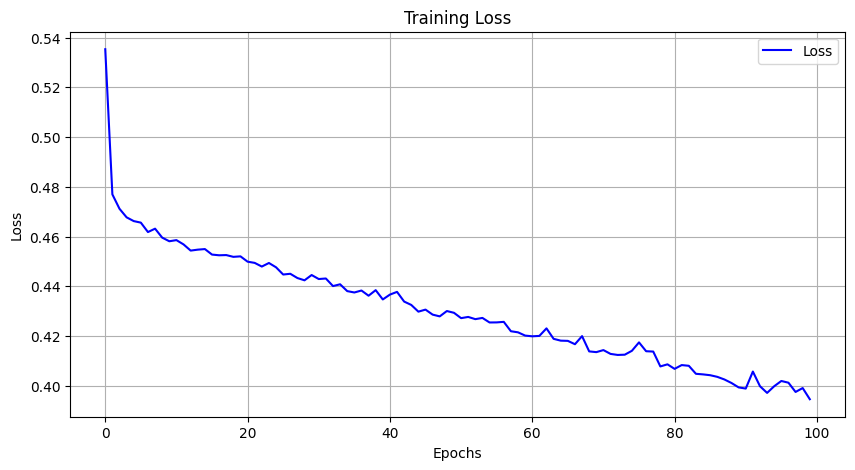

In [43]:
# 13. 绘制训练损失图
plt.figure(figsize=(10, 5))                                # 设置图形大小
plt.plot(np.array(list(range(epochs))),np.array(train_losses), label='Loss', color='blue')         # 绘制损失曲线
plt.title('Training Loss')                                 # 设置图形标题
plt.xlabel('Epochs')                                       # 设置x轴标签
plt.ylabel('Loss')                                         # 设置y轴标签
plt.legend()                                               # 显示图例
plt.grid()                                                 # 显示网格线
plt.show()                                                 # 显示图形

In [44]:
# 20. 保存模型参数
model_path = '/usr/gender_pred_model.pth'    # 模型保存路径
torch.save(model.state_dict(), model_path)    # 保存模型参数
print("保存成功")                             # 提示保存成功

RuntimeError: File /usr/gender_pred_model.pth cannot be opened.

In [ ]:
print(type(x_train))
print(x_train.shape[0] // batch_size)